In [1]:
import tensorflow as tf

keras = tf.keras

tf.__version__

'2.5.0'

# Prepare Data

In [2]:
import tensorflow_datasets as tfds

(train_ds, valid_ds, test_ds), info = tfds.load(
    'sentiment140',
#    split = ['train[0:10%]', 'train[10%:12%]', 'test'],
    split = ['train[0:5%]', 'train[5%:6%]', 'test'],
    as_supervised = True,
    with_info = True,
)

In [3]:
print(info.features['text'].dtype)
print(info.features['polarity'].dtype) # 0 ~ 4

print(info.splits['train'].num_examples)
print(info.splits['test'].num_examples)

<dtype: 'string'>
<dtype: 'int32'>
1600000
498


In [4]:
def decode_text(tensor):
    return tensor.numpy().decode('utf-8')

for text, label in train_ds.take(5):
    print(label.numpy(), decode_text(text), sep = '\t')

4	i'm 10x cooler than all of you! 
0	O.kk? Thats weird I cant stop following people on twitter... I have tons of people to unfollow 
4	what a beautiful day not to got to my first class 
4	.@HildyGottlieb &amp; I was just saying to Maha'al yesterday, everything we ever needed to know was in Beatles' lyrics - you prove my point! 
0	kinda sad and confused  why do guys do this?


In [5]:
vocab_size = 4000
test_sentences = []

for binary_text, _ in test_ds:
    test_sentences.append(decode_text(binary_text))

# https://www.tensorflow.org/datasets/api_docs/python/tfds/deprecated/text/SubwordTextEncoder
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    test_sentences,
    vocab_size,
    max_subword_length = 5,
)
tokenizer.vocab_size

3748

In [6]:
import numpy as np

pos = 0
print(test_sentences[pos])
encoded = tokenizer.encode(test_sentences[pos])
np.array(list(map(lambda i: tokenizer.decode([i]), encoded)))

looks like summize has gone down. too many tweets from WWDC perhaps?


array(['looks', ' ', 'like ', 'summi', 'ze ', 'has ', 'gone ', 'down',
       '. ', 'too ', 'many ', 'tweet', 's ', 'from ', 'WWDC ', 'perha',
       'ps', '?'], dtype='<U5')

In [7]:
from keras.preprocessing.sequence import pad_sequences

batch_size = 32
maxlen = 50

def encode_and_pad_sequence(tensors):
    texts = map(lambda t: t.numpy().decode('utf-8'), tensors)
    encoded = list(map(lambda t: tokenizer.encode(t), texts))
#    print(f'Encoded: {encoded}')
    padded = pad_sequences(
        encoded,
        maxlen = maxlen,
        truncating = 'post',
        padding = 'post',
    )
#    print(f'Padded: {padded}')
#    print(padded.shape)
    return padded

# https://stackoverflow.com/questions/56122670/how-to-get-string-value-out-of-tf-tensor-which-dtype-is-string
@tf.function
def encoder(text):
    return tf.py_function(func=encode_and_pad_sequence, inp=[text], Tout = tf.int32)

def create_test_batch_ds(ds):
    ds = ds.batch(batch_size)
    ds = ds.map(lambda text, label: (encoder(text), label))
    return ds.cache().prefetch(tf.data.AUTOTUNE)

test_batch_ds = create_test_batch_ds(test_ds)
valid_batch_ds = create_test_batch_ds(valid_ds)

for text_batch, _ in test_batch_ds.take(2):
    print(text_batch.shape)
    print(text_batch[0])
    print(text_batch[0].numpy())
    break

(32, 50)
tf.Tensor(
[ 284 3524  102  691  425  136 2051  301    1  263  795  262    9   50
 2602 1579  742 3555    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int32)
[ 284 3524  102  691  425  136 2051  301    1  263  795  262    9   50
 2602 1579  742 3555    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [8]:
def create_train_batch_ds(ds):
    ds = ds.batch(batch_size)
    ds = ds.map(lambda text, label: (encoder(text), label))
    ds = ds.cache()
    return ds.shuffle(1000).prefetch(tf.data.AUTOTUNE)

train_batch_ds = create_train_batch_ds(train_ds)
for text_batch, _ in train_batch_ds.take(2):
    print(text_batch.shape)
    print(text_batch[0])
    print(text_batch[0].numpy())
    break

(32, 50)
tf.Tensor(
[3556  286 3600 3609 3598  767 3563 1869   28   47   10   75 3594 1902
  300   30    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int32)
[3556  286 3600 3609 3598  767 3563 1869   28   47   10   75 3594 1902
  300   30    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


# Build and Train Model

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_item(history_df, colname = 'loss', f = np.min, ax = None):
    val_colname = f'val_{colname}'
    print(f'{colname}: {f(history_df[colname]):.4f} - {val_colname}: {f(history_df[val_colname]):.4f}')
    history_df.loc[:, [colname, val_colname]].plot(title = colname.capitalize() , ax = ax)

def show_history(history):
    history_df = pd.DataFrame(history.history)
    
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
    plot_item(history_df, 'loss', ax = axes[0])
    plot_item(history_df, 'accuracy', ax = axes[1], f = np.max)

## DNN

In [10]:
embedding_dim = 16

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length = maxlen),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(5),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            64000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 8

In [11]:
def fit_model(model, epochs = 500, patience = 2):
    
    model.compile(
        optimizer = 'adam',
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = ['accuracy'],
    )

    early_stopping = keras.callbacks.EarlyStopping(
        patience = patience,
        restore_best_weights = True,
    )

    history = model.fit(
        train_batch_ds, 
        validation_data = valid_batch_ds,
        epochs = epochs,
        callbacks = [early_stopping],
    )
    return history 

Epoch 1/500
2500/2500 [==============================] - 19s 5ms/step - loss: 0.7320 - accuracy: 0.5321 - val_loss: 0.5828 - val_accuracy: 0.7051
Epoch 2/500
2500/2500 [==============================] - 2s 858us/step - loss: 0.5572 - accuracy: 0.7290 - val_loss: 0.5224 - val_accuracy: 0.7411
Epoch 3/500
2500/2500 [==============================] - 2s 852us/step - loss: 0.5149 - accuracy: 0.7561 - val_loss: 0.5128 - val_accuracy: 0.7448
Epoch 4/500
2500/2500 [==============================] - 2s 844us/step - loss: 0.5018 - accuracy: 0.7619 - val_loss: 0.5098 - val_accuracy: 0.7479
Epoch 5/500
2500/2500 [==============================] - 2s 840us/step - loss: 0.4927 - accuracy: 0.7651 - val_loss: 0.5100 - val_accuracy: 0.7464
Epoch 6/500
2500/2500 [==============================] - 2s 848us/step - loss: 0.4863 - accuracy: 0.7676 - val_loss: 0.5097 - val_accuracy: 0.7475
Epoch 7/500
2500/2500 [==============================] - 2s 881us/step - loss: 0.4825 - accuracy: 0.7697 - val_loss: 0.

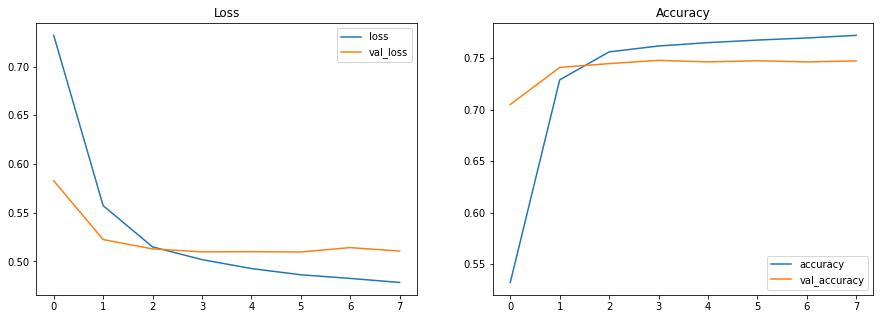

In [12]:
history = fit_model(model)  
show_history(history)

## LSTM

In [13]:
model_bi = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length = maxlen),
    keras.layers.Bidirectional(keras.layers.LSTM(embedding_dim)),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(5),
])

model_bi.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                4224      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
Total params: 69,445
Trainable params: 69,445
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500
2500/2500 [==============================] - 32s 12ms/step - loss: 0.5684 - accuracy: 0.7052 - val_loss: 0.5104 - val_accuracy: 0.7504
Epoch 2/500
2500/2500 [==============================] - 30s 12ms/step - loss: 0.4821 - accuracy: 0.7689 - val_loss: 0.5084 - val_accuracy: 0.7458
Epoch 3/500
2500/2500 [==============================] - 31s 13ms/step - loss: 0.4567 - accuracy: 0.7823 - val_loss: 0.5016 - val_accuracy: 0.7619
Epoch 4/500
2500/2500 [==============================] - 31s 12ms/step - loss: 0.4373 - accuracy: 0.7931 - val_loss: 0.4849 - val_accuracy: 0.7639
Epoch 5/500
2500/2500 [==============================] - 31s 12ms/step - loss: 0.4224 - accuracy: 0.8027 - val_loss: 0.4923 - val_accuracy: 0.7642
Epoch 6/500
2500/2500 [==============================] - 31s 12ms/step - loss: 0.4087 - accuracy: 0.8107 - val_loss: 0.4935 - val_accuracy: 0.7623
loss: 0.4087 - val_loss: 0.4849
accuracy: 0.8107 - val_accuracy: 0.7642


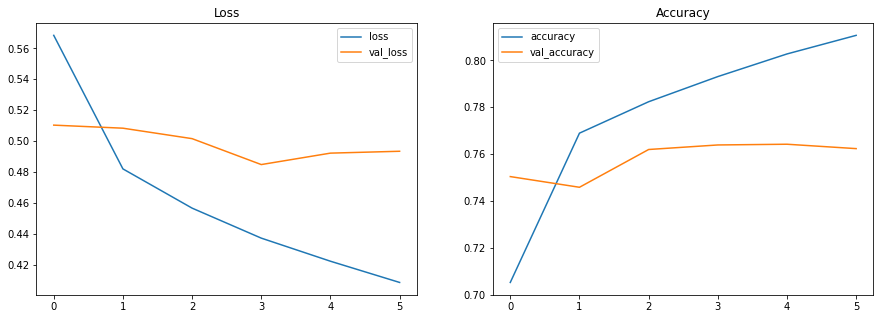

In [14]:
history_bi = fit_model(model_bi)   
show_history(history_bi)

In [15]:
model_multiple_bi = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length = maxlen),
    keras.layers.Bidirectional(keras.layers.LSTM(embedding_dim, return_sequences = True)),
    keras.layers.Bidirectional(keras.layers.LSTM(embedding_dim)),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(5),
])
model_multiple_bi.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 32)            4224      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 165       
Total params: 75,717
Trainable params: 75,717
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500
2500/2500 [==============================] - 62s 24ms/step - loss: 0.5800 - accuracy: 0.6899 - val_loss: 0.5140 - val_accuracy: 0.7494
Epoch 2/500
2500/2500 [==============================] - 59s 24ms/step - loss: 0.4830 - accuracy: 0.7690 - val_loss: 0.4930 - val_accuracy: 0.7604
Epoch 3/500
2500/2500 [==============================] - 59s 24ms/step - loss: 0.4579 - accuracy: 0.7832 - val_loss: 0.4863 - val_accuracy: 0.7657
Epoch 4/500
2500/2500 [==============================] - 60s 24ms/step - loss: 0.4401 - accuracy: 0.7940 - val_loss: 0.4811 - val_accuracy: 0.7664
Epoch 5/500
2500/2500 [==============================] - 59s 24ms/step - loss: 0.4236 - accuracy: 0.8027 - val_loss: 0.4853 - val_accuracy: 0.7653
Epoch 6/500
2500/2500 [==============================] - 60s 24ms/step - loss: 0.4095 - accuracy: 0.8123 - val_loss: 0.4915 - val_accuracy: 0.7687
loss: 0.4095 - val_loss: 0.4811
accuracy: 0.8123 - val_accuracy: 0.7687


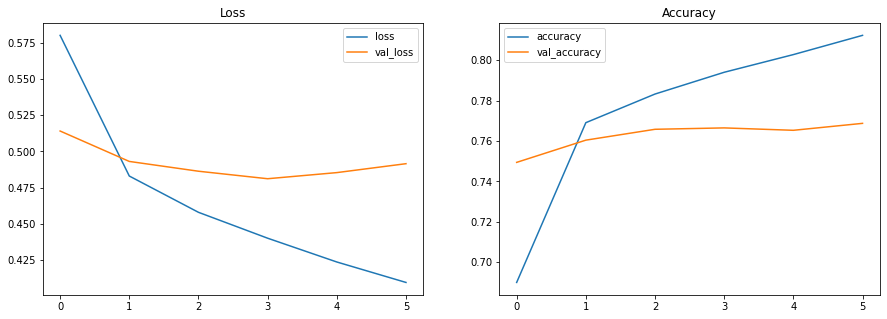

In [16]:
history_multiple_bi = fit_model(model_multiple_bi)   
show_history(history_multiple_bi)

# Reference

[Udacity 187 -  Intro to TensorFlow for Deep Learning - Lession 10: NLP: Recurrent Neural Network](https://classroom.udacity.com/courses/ud187)

* [Colab: Using LSTMs with the Subwords Dataset](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c01_nlp_lstms_with_reviews_subwords_dataset.ipynb)